# Togetherflow
**Emergent agent motion dynamics in immersive rooms**

In this notebook, we implement Togetherflow, a computational cognitive model that characterizes the motion pattern of human agents in immersive rooms.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
# from functools import partial

np.set_printoptions(suppress=True)

In [4]:
import tensorflow as tf
import bayesflow as bf
from bayesflow.simulation import Prior, Simulator, GenerativeModel

In [19]:
from initializations import (
    initialize_agents, 
    initialize_beacons
)
from influences import (
    position_influence,
    rotation_influence,
    alignment_influence,
    cohesion_influence
)
from simulations import (
    look_at_beacon,
    move_to_beacon,
    look_with_neighbors,
    walk_with_neighbors,
    individual_motion,
    collective_motion,
    main_simulator
)

## Initializations

In [6]:
agent_positions, agent_rotations = initialize_agents()
beacon_positions = initialize_beacons()
agent_rotations.shape

(12, 1)

## Influences

### 1. Positional influence (individual)

In [7]:
d = position_influence(agent_positions[0], beacon_positions[1])
d

-0.3499339717200477

### 2. Rotational influence (individual)

In [8]:
direction = rotation_influence(
    agent_positions[0], agent_rotations[0], beacon_positions[1],
)
direction

-0.4561170875082565

## Combined external influence for individual motion

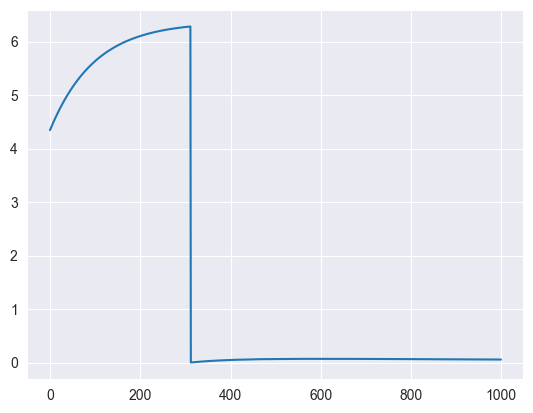

In [9]:
positions, rotations = individual_motion(
    agent_positions[2], agent_rotations[2], beacon_positions[3]
)

plt.plot(rotations)

## 3. Alignment influence (collective)

In [10]:
type(agent_rotations[0].item())

float

In [22]:
p = alignment_influence(
    agent_positions[3],
    agent_positions,
    agent_rotations
)

type(p)

list

## 4. Cohesion influence (collective)

## Combined influence for collective motion

# Prior

In [ ]:
param_names = [
    r"$w$",
    r"$r$",
    r"$v$",
    # r"$\eta$",
    # r"$\kappa$"
]

# Configurator

In [ ]:
def configurator(input_dict: dict = None, transpose: bool = True):
    
    output_dict = {}
    output_dict['parameters'] = input_dict['prior_draws'].astype(np.float32)
    x = input_dict['sim_data'] / 10. 
    if transpose:
        x = np.transpose(x, (0, 2, 1, 3))
    output_dict['summary_conditions'] = x.astype(np.float32)
    return output_dict

# Neural Approximator

In [ ]:
# This one generalizes over different numbers of agents
summary_net = bf.summary_networks.HierarchicalNetwork([
    tf.keras.layers.TimeDistributed(tf.keras.layers.LSTM(units=128)),
    bf.networks.SetTransformer(num_inducing_points=None, input_dim=128, summary_dim=64)
])

inference_net = bf.inference_networks.InvertibleNetwork(
    num_params=3, 
    num_coupling_layers=6,
    coupling_design="affine",
    coupling_settings={
        'kernel_regularizer': None,
        'dropout_prob': 0.0
    }
)

amortizer = bf.amortizers.AmortizedPosterior(
    summary_net=summary_net, 
    inference_net=inference_net
)

# Training

In [ ]:
# trainer = bf.trainers.Trainer(
#     amortizer=amortizer,
#     generative_model=model,
#     configurator=configurator
# )

### Offline training

In [ ]:
# training_set = model(1000) 

In [ ]:
# losses = trainer.train_offline(training_set, epochs=100, batch_size=100, validation_sims=model(200))